In [1]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import chess
import chess.svg
import cairosvg
import io
from PIL import Image

2024-03-08 15:07:27.733488: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 15:07:27.766125: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 15:07:27.892437: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 15:07:27.892481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 15:07:27.912948: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
model = load_model('model.h5')

classes = ['black_bishop', 'black_king', 'black_knight', 'black_pawn', 'black_queen', 'black_rook',
           'empty', 'white_bishop', 'white_king', 'white_knight', 'white_pawn', 'white_queen', 'white_rook']
le = LabelEncoder()
le.classes_ = np.array(classes)

img_dim = 50

def split_board_to_squares(image_path):
    img = cv2.imread(image_path)
    squares = []
    square_size = img.shape[0] // 8
    for row in range(8):
        for col in range(8):
            square = img[row*square_size:(row+1)*square_size, col*square_size:(col+1)*square_size]
            squares.append(cv2.resize(square, (img_dim, img_dim)))
    return squares

def predictions_to_fen(predicted_labels):
    rows = []
    for i in range(0, 64, 8):
        row_labels = predicted_labels[i:i+8]
        row_fen = ''
        empty = 0
        for label in row_labels:
            if label == 'empty':
                empty += 1
            else:
                if empty > 0:
                    row_fen += str(empty)
                    empty = 0
                piece_mapping = {
                    'pawn': 'p', 'knight': 'n', 'bishop': 'b',
                    'rook': 'r', 'queen': 'q', 'king': 'k'
                }
                piece_type = label.split('_')[1]
                piece = piece_mapping.get(piece_type, '')
                if 'white' in label:
                    piece = piece.upper()
                row_fen += piece
        if empty > 0:
            row_fen += str(empty)
        rows.append(row_fen)

    complete_fen = f"{'/'.join(rows)} w - - 0 1"
    return complete_fen

2/2 [==============================] - 0s 7ms/step


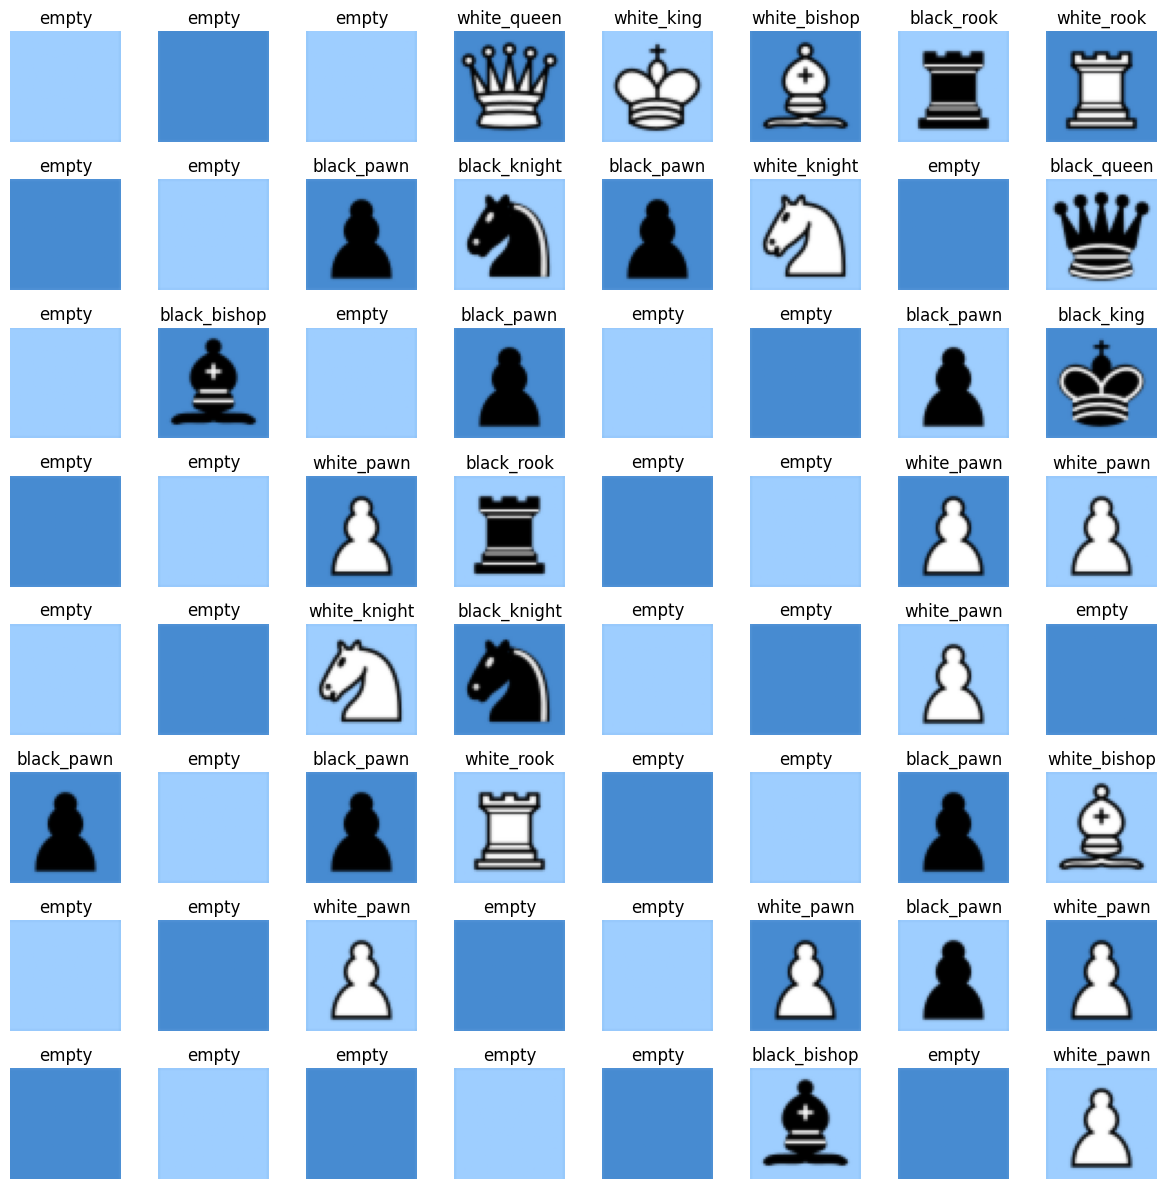

In [10]:
image_path = 'screenshots/chessboard2.png'
squares = split_board_to_squares(image_path)
squares = np.array([img_to_array(square) for square in squares])
squares = squares.astype('float32') / 255.0

predictions = model.predict(squares)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [le.inverse_transform([pred])[0] for pred in predicted_classes]

# print each case
fig, ax = plt.subplots(8, 8, figsize=(12, 12))
for i, label in enumerate(predicted_labels):
    ax[i // 8, i % 8].imshow(squares[i])
    ax[i // 8, i % 8].set_title(label)
    ax[i // 8, i % 8].axis('off')

plt.tight_layout()
plt.show()

fen_predicted = predictions_to_fen(predicted_labels)

In [4]:
svg = chess.svg.board(board=chess.Board(fen=fen_predicted))
svg_bytes = svg.encode('utf-8')

png_bytes = cairosvg.svg2png(bytestring=svg_bytes)

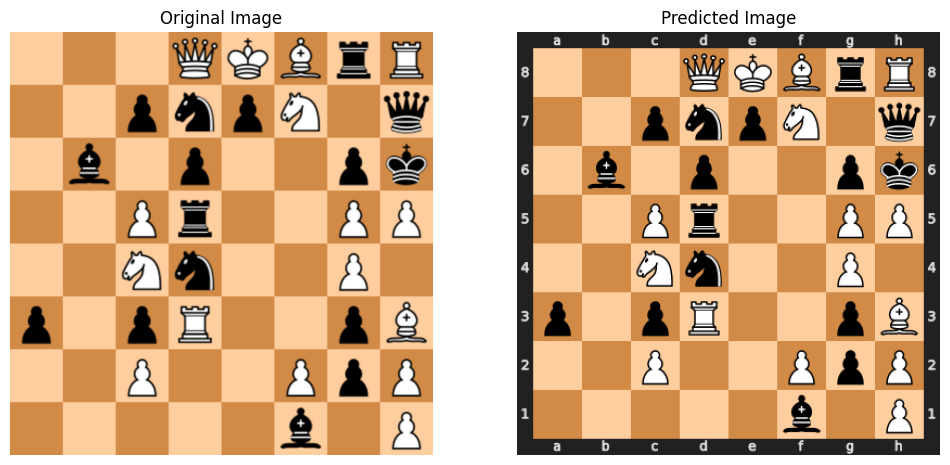

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
original_img = cv2.imread(image_path)
ax[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[0].axis('off')

predicted_img = Image.open(io.BytesIO(png_bytes))
ax[1].imshow(predicted_img)
ax[1].set_title('Predicted Image')
ax[1].axis('off')

plt.show()